In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
from scipy.optimize import curve_fit
import sys
from numba import jit
import warnings
import cv2
from PIL import Image as im
import random

In [2]:
def get_norm(array):
    '''
    DEF: Normaliation of probe beam intensity/power fluctuation by Frobenious norm
    INPUT: 2D image frame
    OUTPUT: Normalized 2D image frame
    '''
    return array / np.sqrt(np.sum(np.square(array)))


def preprocess_data(frame, dark_frame, vertical_start, vertical_end, horizontal_start, horizontal_end, norm):
    '''
    DEF: Prepares image frames by removing dark noises, then crops the frame and then does intensity fluctuation
        normalization by Frobenious norm if norm=True. If norm=False, normalization is skipped
    INPUT: Image frame to be pre-processed, corresponding dark frame or avg dark frame, cropping start index along vertical,
        cropping end index along vertical, cropping start index along horizontal, cropping end index along horizontal
    OUTPUT: Background subtracted, cropped and normalized frame if norm=True. Backgroud subtracted and cropped frame if norm=False
    '''
    bg_sub_frame = frame - dark_frame
    cropped_frame = bg_sub_frame[vertical_start:vertical_end, horizontal_start:horizontal_end]
    if norm == True:
        normalized_frame = get_norm(cropped_frame)
        return normalized_frame 
    else:
        return cropped_frame


def gauss(xdata, off, amp, mu, sd):
    '''
    DEF: Creates a 1D Gaussian distribution
    INPUT: X values in 1D array, Offset, Amplitude, Mean and Standard Deviation of the distribution
    OUTPUT: Gaussian 1D distribution corresponding to given input parameters
    '''
    return off + amp * (np.exp(-(xdata - mu)**2 / (2*sd**2)))


def denoise_by_pattern_recognise(abs_frames, masked_abs_frames_dictionary, ref_frames_dictionary, nof_abs, nof_ref, frame_dimension, 
density_start_idx1, density_end_idx1, density_start_idx2, density_end_idx2):
    '''
    DEF: Reconstruct suitable referance frames by recognising fringe patterns
    INPUT: Absorption frames, absorption frames dictioanry masked by referance frames, referance frame basis, number of absorption frames,
        number of reference frames, sqaure dimension of the frame, noise floor start1, noise floor end1, noise floor start2, noise floor end2
    OUTPUT: Reconstructed referance frames for each absorption frames
    '''
    gamma_i = [ref_frames_dictionary[i].flatten() for i in range(nof_ref)]
    gamma_i = np.asarray(gamma_i)
    psi = np.mean(gamma_i, axis = 0)
    phi_i = [gamma_i[i] - psi for i in range(nof_ref)]
    phi_i = np.asarray(phi_i)
    gamma_abs = [masked_abs_frames_dictionary[i].flatten() for i in range(nof_abs)]
    gamma_abs = np.asarray(gamma_abs)
    phi_abs = [gamma_abs[i] - psi for i in range(nof_abs)]
    phi_abs = np.asarray(phi_abs)
    A = np.zeros([frame_dimension*frame_dimension, nof_ref])
    for i in range(nof_ref):
        A[:,i] = phi_i[i]
    cov_mat = np.matmul(np.transpose(A), A)
    cov_mat = np.array(cov_mat)
    eig_val, eig_vec = np.linalg.eig(cov_mat)
    V_i = eig_vec
    V_i.shape
    U_i = []
    for i in range(nof_ref):
        V_i[i] = V_i[i] / np.linalg.norm(V_i[i])
        u_i = np.matmul(A, V_i[i])
        U_i.append(u_i/np.linalg.norm(u_i))
    U_i = np.asarray(U_i)
    optimized_new_ref = []
    xdata = np.arange(0, frame_dimension, 1)
    for i in range(nof_abs):
        unoptimized_new_ref = []
        for j in range(len(U_i)):
            tmp_phi = np.zeros(frame_dimension*frame_dimension)
            for k in range(j):
                tmp_phi = tmp_phi + (np.matmul(np.transpose(U_i[k]),phi_abs[i]))*U_i[k]
            unoptimized_new_ref.append((tmp_phi + psi).reshape(frame_dimension,frame_dimension))
        unoptimized_od = [np.log(np.divide(unoptimized_new_ref[m], abs_frames[i])) for m in range(len(unoptimized_new_ref))]
        gi = od_optimization(unoptimized_od, density_start_idx1, density_end_idx1, density_start_idx2, density_end_idx2, 1)
        optimized_new_ref.append(unoptimized_new_ref[gi])
    return optimized_new_ref
    #return eig_val
    

def cloud_size_estimation(optical_density, density_start_idx1, density_end_idx1, density_start_idx2, density_end_idx2):
    '''
    DEF: Rough estimates of clold size
    INPUT: Optical density, noise floor end1, noise floor start2, noise floor end2
    OUTPUT: Size of cloud in pixel
    '''
    h_axis_scan_first_half_max = []
    h_axis_scan_first_half_min = []
    h_axis_scan_second_half_max = []
    h_axis_scan_second_half_min = []
    v_axis_scan_first_half_max = []
    v_axis_scan_first_half_min = []
    v_axis_scan_second_half_max = []
    v_axis_scan_second_half_min = []
    for i in range(density_start_idx1, density_end_idx1):
        bg_list = optical_density[:,i]
        h_axis_scan_first_half_max.append(np.max(bg_list))
        h_axis_scan_first_half_min.append(np.min(bg_list))
    for i in range(density_start_idx2,density_end_idx2):
        bg_list = optical_density[:,i]
        h_axis_scan_second_half_max.append(np.max(bg_list))
        h_axis_scan_second_half_min.append(np.min(bg_list))
    for i in range(density_start_idx1, density_end_idx1):
        bg_list = optical_density[i,:]
        v_axis_scan_first_half_max.append(np.max(bg_list))
        v_axis_scan_first_half_min.append(np.min(bg_list))  
    for i in range(density_start_idx2,density_end_idx2):
        bg_list = optical_density[i,:]
        v_axis_scan_second_half_max.append(np.max(bg_list))
        v_axis_scan_second_half_min.append(np.min(bg_list))
    bg_list_max = np.array([h_axis_scan_first_half_max, h_axis_scan_second_half_max, v_axis_scan_first_half_max, v_axis_scan_second_half_max])
    bg_list_min = np.array([h_axis_scan_first_half_min, h_axis_scan_second_half_min, v_axis_scan_first_half_min, v_axis_scan_second_half_min])
    bg_max = np.max(bg_list_max)
    bg_min = np.min(bg_list_min)
    masking_pair = []
    for i in range(len(optical_density)):
        for j in range(len(optical_density)):
            if optical_density[i][j] >= bg_max:
                masking_pair.append((i,j))
            else:
                continue
    return round(np.sqrt(len(masking_pair)/4))


def hide_cloud(abs_frames, ref_frames, nof_abs, frame_dimension, cloud_size_guess, param_col, param_row):
    '''
    DEF: Hide the cloud information and replace with probe beam part
    INPUT: Absorption frames, reference frames, number of absorption frames, frame sqaure dimension, rough cloud size, 
        fitting parameters for column sum, fitting parameters for row sum
    OUTPUT: Absorption frame where cloud information is hidden
    '''
    masked_abs_frames = []
    for i in range(nof_abs):
        tmp_abs_frame = abs_frames[i].copy()
        for j in range(frame_dimension):
            for k in range(frame_dimension):
                if (j-param_row[i][2])**2+(k-param_col[i][2])**2 < (cloud_size_guess*2)**2:
                    tmp_abs_frame[j,k] = ref_frames[i][j,k]
        masked_abs_frames.append(tmp_abs_frame)
    masked_abs_frames = np.asarray(masked_abs_frames)
    return masked_abs_frames


def od_optimization(od_list, density_start_idx1, density_end_idx1, density_start_idx2, density_end_idx2, condition):
    '''
    DEF: Finds best or worst od in a given od list depending on condition given. If condition=0, this returns worst od
    INPUT: Optical density list, noise floor start1, noise floor end1, noise floor start2, noise floor end2, optimization condition
    OUTPUT: Best od if condition=1 and vice-versa
    '''
    sd_list = []
    for i in od_list:
        col_sum = np.sum(i, axis = 0)
        row_sum = np.sum(i, axis = 1)
        sd =  abs(np.std(col_sum)) + abs(np.std(row_sum)) + np.median(col_sum) + np.median(row_sum)
        sd_list.append(sd)
    if condition == 0:
        return np.argmax(sd_list)
    else:
        return np.argmin(sd_list)


def od_optimization2(od_list, density_start_idx1, density_end_idx1, density_start_idx2, density_end_idx2, condition):
    '''
    DEF: Reconstruct suitable referance frames by recognising fringe patterns
    INPUT: Absorption frames, absorption frames dictioanry masked by referance frames, referance frame basis, number of absorption frames,
        number of reference frames, sqaure dimension of the frame, noise floor start1, noise floor end1, noise floor start2, noise floor end2
    OUTPUT: Reconstructed referance frames for each absorption frames
    '''
    sd_list = []
    for i in od_list:
        col_sum = np.sum(i, axis = 0)
        row_sum = np.sum(i, axis = 1)
        sd = np.max(col_sum[density_start_idx1:density_end_idx1]) - np.min(col_sum[density_start_idx1:density_end_idx1])
        + np.max(col_sum[density_start_idx2:density_end_idx2]) - np.min(col_sum[density_start_idx2:density_end_idx2])
        + np.max(row_sum[density_start_idx1:density_end_idx1]) - np.min(row_sum[density_start_idx1:density_end_idx1])
        + np.max(row_sum[density_start_idx2:density_end_idx2]) - np.min(row_sum[density_start_idx2:density_end_idx2])
        sd_list.append(sd)
    if condition == 0:
        return np.argmax(sd_list)
    else:
        return np.argmin(sd_list)


def get_edged_od(optical_density, vertical_bg_start_1, vertical_bg_end_1, vertical_bg_start_2, vertical_bg_end_2, 
horizontal_bg_start_1, horizontal_bg_end_1, horizontal_bg_start_2, horizontal_bg_end_2):
    '''
    DEF: Detects edge of cloud and masked it
    INPUT: Optical density, vertical noise floor start1, vertical noise flooed end1, vertical noise floor start2, vertical noise flooed end2, 
        horizontal noise floor start1, horizontal noise flooed end1, horizontal noise floor start2, horizontal noise flooed end2
    OUTPUT: Returns edge-cropped optical density
    '''
    h_axis_scan_first_half_max = []
    h_axis_scan_first_half_min = []
    h_axis_scan_second_half_max = []
    h_axis_scan_second_half_min = []
    v_axis_scan_first_half_max = []
    v_axis_scan_first_half_min = []
    v_axis_scan_second_half_max = []
    v_axis_scan_second_half_min = []
    for i in range(horizontal_bg_start_1,horizontal_bg_end_1):
        bg_list = optical_density[:,i]
        h_axis_scan_first_half_max.append(np.max(bg_list))
        h_axis_scan_first_half_min.append(np.min(bg_list))
    for i in range(horizontal_bg_start_2,horizontal_bg_end_2):
        bg_list = optical_density[:,i]
        h_axis_scan_second_half_max.append(np.max(bg_list))
        h_axis_scan_second_half_min.append(np.min(bg_list))
    for i in range(vertical_bg_start_1,vertical_bg_end_1):
        bg_list = optical_density[i,:]
        v_axis_scan_first_half_max.append(np.max(bg_list))
        v_axis_scan_first_half_min.append(np.min(bg_list))
    for i in range(vertical_bg_start_2,vertical_bg_end_2):
        bg_list = optical_density[i,:]
        v_axis_scan_second_half_max.append(np.max(bg_list))
        v_axis_scan_second_half_min.append(np.min(bg_list))
    bg_list_max = np.array([h_axis_scan_first_half_max, h_axis_scan_second_half_max, v_axis_scan_first_half_max, v_axis_scan_second_half_max])
    bg_list_min = np.array([h_axis_scan_first_half_min, h_axis_scan_second_half_min, v_axis_scan_first_half_min, v_axis_scan_second_half_min])
    bg_max = np.max(bg_list_max)
    bg_min = np.min(bg_list_min)
    masking_pair_i = []
    masking_pair_j = []
    masking_pair_values = []
    edge_od = optical_density.copy()
    for i in range(len(optical_density)):
        for j in range(len(optical_density)):
            if edge_od[i][j] >= bg_max:
                masking_pair_i.append(i)
                masking_pair_j.append(j)
                masking_pair_values.append(edge_od[i][j])
                edge_od[i][j] = bg_max
            else:
                continue
    return edge_od


def show_denoise_performance(old_od, new_od, index, colormap, color_max, color_min, subplot_title):
    '''
    DEF: Plots denoising performance
    INPUT: Unprocessed od, processed od, frame index, colormap, color min, color max, subplot title
    OUTPUT: Subplots
    '''
    plt.rcParams['figure.figsize'] = [20,10]
    #plt.suptitle(subplot_title)
    #plt.subplot(1,4,1)
    # plt.imshow(old_od[index], cmap = colormap, vmin = color_min, vmax = color_max)
    # plt.title("Noisy OD")
    # plt.colorbar()
    # plt.axis('off')
    os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\paper")
    
    # plt.subplot(1,4,2)
    # plt.imshow(new_od[index], cmap = colormap, vmin = color_min, vmax = color_max)
    # plt.title("Processed OD")
    # plt.colorbar()
    # plt.subplot(1,4,3)
    # plt.title("Column density plot")
    # plt.plot(np.sum(old_od[index], axis = 0), 'r', label = "Noisy", alpha = 0.4, linewidth=2)
    # plt.plot(np.sum(new_od[index], axis = 0), 'b', label = "Stage 1 processed", linewidth = 2)
    # plt.grid()
    # plt.legend()
    # plt.subplot(1,4,4)
    # plt.title("Density plot")
    plt.subplot(1,2,1)
    #plt.title("Noisy density plot", fontsize = 20)
    plt.plot(np.sum(old_od[index], axis = 1)+abs(np.min(np.sum(old_od[index], axis = 1))), 'r', alpha = 0.8, linewidth=2)
    plt.tick_params(direction = "in", right = "True", top = "True", labelsize = 20)
    plt.xlabel("Pixel number", fontsize = 24)
    plt.ylabel("Column density (arb. unit)", fontsize = 24)
    plt.ylim([0,18])
    plt.xlim([0,220])
    plt.subplot(1,2,2)
    #plt.title("Processed density plot", fontsize = 20)
    plt.plot(np.sum(new_od[index], axis = 1)+abs(np.min(np.sum(new_od[index], axis = 1)))+2, 'b', alpha=0.8, linewidth = 2)
    plt.tick_params(direction = "in", right = "True", top = "True", labelsize = 20)
    #plt.grid()
    plt.xlabel("Pixel number", fontsize = 24)
    plt.ylabel("Column density (arb. unit)", fontsize = 24)
    plt.ylim([0,18])
    plt.xlim([0,220])
    
    #plt.savefig("modified_lsnr.png", dpi = 1000)


@jit()
def create_gaussian(shape, a):
    tmpx = (shape[0]-1)/2
    tmpy = (shape[1]-1)/2
    x_idx = np.arange(-tmpx, tmpx+1)
    y_idx = np.arange(-tmpy, tmpy+1)
    y_idx = y_idx.reshape(shape[1], 1)
    gauss = np.exp(-(x_idx*x_idx+y_idx*y_idx)/(2*a*a))
    gauss= np.divide(gauss, np.sum(gauss))
    return gauss


@jit()
def weighted_dist(i, j, w, var):
    diff = i - j
    return (w*(diff*diff - 2*var)).sum()


@jit()
def nl_means(noisy_image, patch_size, search_size, h, sigma, a):
    w = create_gaussian((patch_size, patch_size), a)
    to_pad = patch_size//2
    padded_noisy_image = np.pad(noisy_image, (to_pad, to_pad), mode="reflect")
    pred=np.zeros(noisy_image.shape)
    for i in range(to_pad, padded_noisy_image.shape[0]-to_pad):
        for j in range(to_pad, padded_noisy_image.shape[1]-to_pad):
            curr_patch = padded_noisy_image[i-to_pad:i+to_pad+1, j-to_pad:j+to_pad+1]
            total_sum = 0
            for a in range(i-search_size//2, i+(search_size//2)+1):
                if a-to_pad<0:
                    continue
                if a+to_pad>=padded_noisy_image.shape[0]:
                    break
                for b in range(j-search_size//2, j+(search_size//2)+1):
                    if b-to_pad<0 or (a==i and b==j):
                        continue
                    if b+to_pad>=padded_noisy_image.shape[1]:
                        break
                    search_patch = padded_noisy_image[a-to_pad:a+to_pad+1, b-to_pad:b+to_pad+1]
                    weight = np.exp(-weighted_dist(curr_patch, search_patch, w, sigma**2)/h**2)
                    total_sum += weight
                    pred[i-to_pad, j-to_pad] += weight*padded_noisy_image[a, b]
            pred[i-to_pad, j-to_pad] /=total_sum
    return pred


def denoise(optical_density, vertical_bg_start_1, vertical_bg_end_1, vertical_bg_start_2, vertical_bg_end_2, 
horizontal_bg_start_1, horizontal_bg_end_1, horizontal_bg_start_2, horizontal_bg_end_2):
    warnings.filterwarnings('ignore')
    patch_size= 3 #7
    search_size = 15 #20
    sigma = 10 #0.11
    h = 0.8*sigma #0.1
    a = 1.5 #1.5
    edge_od = get_edged_od(optical_density, vertical_bg_start_1, vertical_bg_end_1, vertical_bg_start_2, vertical_bg_end_2, 
    horizontal_bg_start_1, horizontal_bg_end_1, horizontal_bg_start_2, horizontal_bg_end_2)
    denoised_od = nl_means(edge_od, patch_size, search_size, h, sigma, a)
    
    return denoised_od + (optical_density - edge_od)


def show_overall_denoising_performance(old_od, new_od1, new_od2, index, colormap, color_max, color_min, subplot_title):
    '''
    DEF: Plots overall denoising performance
    INPUT: Unprocessed od, processed1 od, processed2 od, frame index, colormap, color min, color max, subplot title, saving output path, save or not
    OUTPUT: Subplots
    '''
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.suptitle(subplot_title)
    plt.subplot(2,3,1)
    plt.imshow(old_od[index], cmap = colormap, vmin = color_min, vmax = color_max)
    plt.title("Un-processed OD")
    plt.colorbar()
    plt.subplot(2,3,2)
    plt.imshow(new_od1[index], cmap = colormap, vmin = color_min, vmax = color_max)
    plt.title("Stage-I processed OD")
    plt.colorbar()
    plt.subplot(2,3,3)
    plt.imshow(new_od2[index], cmap = colormap, vmin = color_min, vmax = color_max)
    plt.title("Stage-II processed OD")
    plt.colorbar()
    plt.subplot(2,3,4)
    plt.title("Column density plot")
    plt.plot(np.sum(old_od[index], axis = 0), 'k', label = "Un-processed")
    plt.plot(np.sum(new_od1[index], axis = 0), 'r', label = "Stage-I processed")
    plt.plot(np.sum(new_od2[index], axis = 0), 'b', label = "Stage-II processed")
    plt.grid()
    plt.legend()
    plt.subplot(2,3,5)
    plt.title("Row density plot")
    plt.plot(np.sum(old_od[index], axis = 1), 'k', label = "Un-processed")
    plt.plot(np.sum(new_od1[index], axis = 1), 'r', label = "Stage-I processed")
    plt.plot(np.sum(new_od2[index], axis = 1), 'b', label = "Stage-I processed")
    plt.grid()
    plt.legend()


def save_performance_plots(old_od, new_od1, new_od2, colormap, color_max, color_min, subplot_title, saving_path, action):
    if action == False:
        print("Set action=True to save denoised od files...")
    else:
        for i in range(len(old_od)):
            plt.rcParams['figure.figsize'] = [25, 10]
            plt.suptitle(subplot_title)
            plt.subplot(2,3,1)
            plt.imshow(old_od[i], cmap = colormap, vmin = color_min, vmax = color_max)
            plt.title("Un-processed OD")
            plt.colorbar()
            plt.subplot(2,3,2)
            plt.imshow(new_od1[i], cmap = colormap, vmin = color_min, vmax = color_max)
            plt.title("Stage-I processed OD")
            plt.colorbar()
            plt.subplot(2,3,3)
            plt.imshow(new_od2[i], cmap = colormap, vmin = color_min, vmax = color_max)
            plt.title("Stage-II processed OD")
            plt.colorbar()
            plt.subplot(2,3,4)
            plt.title("Column density plot")
            plt.plot(np.sum(old_od[i], axis = 0), 'k', label = "Un-processed")
            plt.plot(np.sum(new_od1[i], axis = 0), 'r', label = "Stage-I processed")
            plt.plot(np.sum(new_od2[i], axis = 0), 'b', label = "Stage-II processed")
            plt.grid()
            plt.legend()
            plt.subplot(2,3,5)
            plt.title("Row density plot")
            plt.plot(np.sum(old_od[i], axis = 1), 'k', label = "Un-processed")
            plt.plot(np.sum(new_od1[i], axis = 1), 'r', label = "Stage-I processed")
            plt.plot(np.sum(new_od2[i], axis = 1), 'b', label = "Stage-I processed")
            plt.grid()
            plt.legend()
            raw_saving_path = saving_path.encode('unicode_escape')
            os.chdir(saving_path)
            output_filename = "frame" + "_" + str(i) + "." + "jpg"
            plt.savefig(output_filename, dpi = 1000)
            plt.clf();

In [3]:
full_path_to_absorption_data_files = r"P:\DATASETS\RRI_Rb_Absorption_dataset2"
full_path_to_reference_data_files = r"P:\DATASETS\RRI_Rb_Absorption_dataset2"
full_path_to_background_data_files = r"P:\DATASETS\RRI_Rb_Absorption_dataset2"
full_path_image_output_saving = r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\Rb_set2_results\image_output"

In [4]:
os.chdir(full_path_to_absorption_data_files.encode('unicode_escape'))
abs_files = ['temp_{}_{}_1.asc'.format(i+1, j+1) for i in range(3) for j in range(6)]
raw_abs_frames = [pd.read_csv(filename, sep = ',').iloc[:,1:-2].to_numpy() for filename in abs_files]

os.chdir(full_path_to_reference_data_files.encode('unicode_escape'))
ref_files = ['temp_{}_{}_2.asc'.format(i+1, j+1) for i in range(3) for j in range(6)]
raw_ref_frames = [pd.read_csv(filename, sep = ',').iloc[:,1:-2].to_numpy() for filename in ref_files]

os.chdir(full_path_to_background_data_files.encode('unicode_escape'))
bg_files = ['temp_{}_{}_3.asc'.format(i+1, j+1) for i in range(3) for j in range(6)]
raw_bg_frames = [pd.read_csv(filename, sep = ',').iloc[:,1:-2].to_numpy() for filename in bg_files]

In [5]:
len(abs_files)

18

In [6]:
# os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing")
# np.savetxt("wo_frob_0.csv", np.sum(raw_ref_frames[0], axis = 1), delimiter=',', fmt='%d')
# np.savetxt("wo_frob_5.csv", np.sum(raw_ref_frames[5], axis = 1), delimiter=',', fmt='%d')
# np.savetxt("wo_frob_10.csv", np.sum(raw_ref_frames[10], axis = 1), delimiter=',', fmt='%d')
# np.savetxt("wo_frob_15.csv", np.sum(raw_ref_frames[15], axis = 1), delimiter=',', fmt='%d')

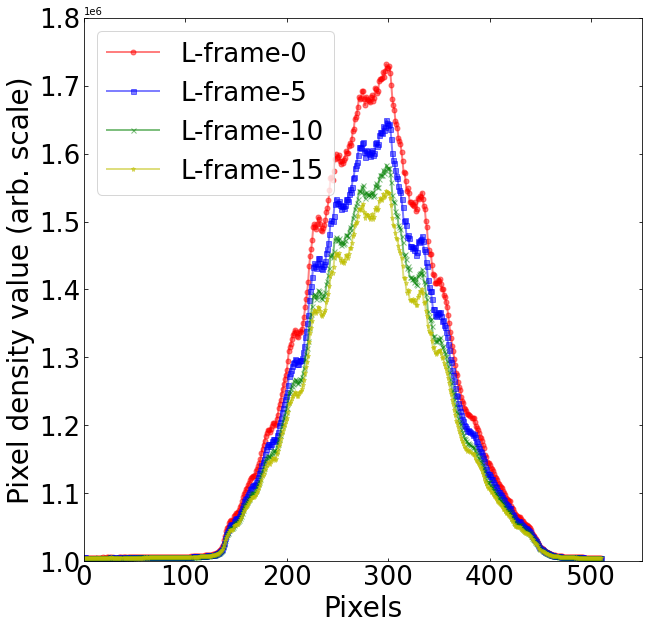

In [7]:
plt.rcParams['figure.figsize'] = [10,10]
plt.plot(np.sum(raw_ref_frames[0], axis = 1), "ro-", alpha = 0.5, linewidth = 2, label = "L-frame-0", markersize=5)
plt.plot(np.sum(raw_ref_frames[5], axis = 1), "bs-", alpha = 0.5, linewidth = 2, label = "L-frame-5", markersize=5)
plt.plot(np.sum(raw_ref_frames[10], axis = 1), "gx-", alpha = 0.5, linewidth = 2, label = "L-frame-10", markersize=5)
plt.plot(np.sum(raw_ref_frames[15], axis = 1), "y*-", alpha = 0.5, linewidth = 2, label = "L-frame-15", markersize=5)

plt.legend(fontsize="26", loc ="upper left")
plt.tick_params(direction = "in", right = "True", top = "True", labelsize = 26)
plt.xlim([0,550])
plt.ylim([1E6,1.8E6])
plt.xlabel("Pixels", fontsize = 28)
plt.ylabel("Pixel density value (arb. scale)", fontsize = 28)
os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\paper")
#plt.savefig("without_norm_intensity_fluctuation.png", dpi = 1000)

In [8]:
nof_abs = len(raw_abs_frames)
nof_ref = len(raw_ref_frames)
nof_bg = len(raw_bg_frames)
approx_cloud_center = [round((np.argmax(np.sum(np.log(np.divide(raw_ref_frames[i], raw_abs_frames[i])), axis = 0)) + 
np.argmax(np.sum(np.log(np.divide(raw_ref_frames[i], raw_abs_frames[i])), axis = 1)))/2) for i in range(nof_abs)]
cloud_column_position = [np.argmax(np.sum(np.log(np.divide(raw_ref_frames[i], raw_abs_frames[i])), axis = 0)) for i in range(nof_abs)]
cloud_row_position = [np.argmax(np.sum(np.log(np.divide(raw_ref_frames[i], raw_abs_frames[i])), axis = 1)) for i in range(nof_abs)]
raw_dimension = np.shape(raw_ref_frames[0])
cropped_dim = np.min(np.min(raw_dimension) - approx_cloud_center[-1])
if (cropped_dim%2)!=0:
    cropped_dim = cropped_dim-1
vertical_start, vertical_end, horizontal_start, horizontal_end = [], [], [], []
for i in range(nof_abs):
    vertical_start.append(cloud_row_position[i] - round(cropped_dim/2))
    vertical_end.append(cloud_row_position[i] + round(cropped_dim/2))
    horizontal_start.append(cloud_column_position[i] - round(cropped_dim/2))
    horizontal_end.append(cloud_column_position[i] + round(cropped_dim/2))
density_start_idx1 = 0
density_end_idx1 = round(cropped_dim/4)
density_start_idx2 = cropped_dim - round(cropped_dim/4)
density_end_idx2 = cropped_dim
vertical_bg_start_1 = density_start_idx1
vertical_bg_end_1 = density_end_idx1
vertical_bg_start_2 = density_start_idx2
vertical_bg_end_2 = density_end_idx2
horizontal_bg_start_1 = density_start_idx1
horizontal_bg_end_1 = density_end_idx1
horizontal_bg_start_2 = density_start_idx2
horizontal_bg_end_2 = density_end_idx2

In [9]:
vertical_start[0], vertical_end[0], horizontal_start[0], horizontal_end[0]

(158, 370, 219, 431)

In [10]:
abs_frames, ref_frames = [], []
for i in range(nof_abs):
    abs_frames.append(preprocess_data(raw_abs_frames[i], raw_bg_frames[i], vertical_start = vertical_start[0], 
    vertical_end = vertical_end[0], horizontal_start = horizontal_start[0], 
    horizontal_end = horizontal_end[0], norm = True))
for i in range(nof_ref):
    ref_frames.append(preprocess_data(raw_ref_frames[i], raw_bg_frames[i], vertical_start = vertical_start[0], 
    vertical_end = vertical_end[0], horizontal_start = horizontal_start[0], 
    horizontal_end = horizontal_end[0], norm = True))

(-0.5, 211.5, 211.5, -0.5)

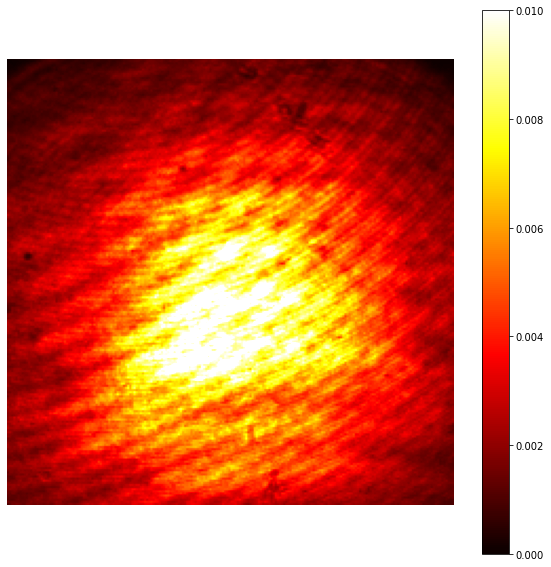

In [11]:
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(ref_frames[14], cmap = "hot", vmin = 0, vmax = 0.01)
plt.axis("off");
os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\paper")
plt.colorbar()
plt.axis("off")
#plt.savefig("ref_frame_with_cbar.png", dpi = 1000)

In [12]:
# os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\frobenious_origin")
# np.savetxt("w_frob_0.csv", np.sum(ref_frames[0], axis = 1), delimiter=',')
# np.savetxt("w_frob_5.csv", np.sum(ref_frames[5], axis = 1), delimiter=',')
# np.savetxt("w_frob_10.csv", np.sum(ref_frames[10], axis = 1), delimiter=',')
# np.savetxt("w_frob_15.csv", np.sum(ref_frames[15], axis = 1), delimiter=',')

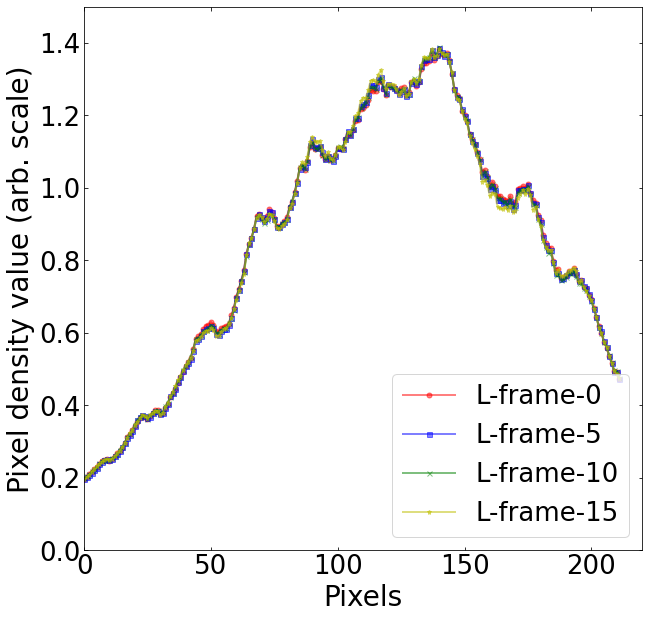

In [13]:
plt.rcParams['figure.figsize'] = [10,10]
plt.plot(np.sum(ref_frames[0], axis = 1), "ro-", alpha = 0.5, linewidth = 2, label = "L-frame-0", markersize=5)
plt.plot(np.sum(ref_frames[5], axis = 1), "bs-", alpha = 0.5, linewidth = 2, label = "L-frame-5", markersize=5)
plt.plot(np.sum(ref_frames[10], axis = 1), "gx-", alpha = 0.5, linewidth = 2, label = "L-frame-10", markersize=5)
plt.plot(np.sum(ref_frames[15], axis = 1), "y*-", alpha = 0.5, linewidth = 2, label = "L-frame-15", markersize=5)

plt.legend(fontsize="26", loc ="lower right")
plt.tick_params(direction = "in", right = "True", top = "True", labelsize = 26)
plt.xlim([0,220])
plt.ylim([0, 1.5])
plt.xlabel("Pixels", fontsize = 28)
plt.ylabel("Pixel density value (arb. scale)", fontsize = 28)
os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\paper")
#plt.savefig("with_norm_intensity_fluctuation.png", dpi = 1000)

In [14]:
frame_dimension = np.shape(abs_frames[0])[0]
xdata = np.arange(0, frame_dimension, 1)
colormap = "jet"
gaussian_function_fiiting_method = "lm"
gaussian_function_fiiting_max_iteration = 100000
color_min = -0.25
color_max = 0.55

In [15]:
old_od_lists_sorted = []
for i in range(nof_abs):
    old_od = []
    for j in range(nof_ref):
        old_od.append(np.log(np.divide(ref_frames[j], abs_frames[i])))
    old_od_lists_sorted.append(old_od)
bad_index = [od_optimization2(old_od_lists_sorted[i], density_start_idx1 = density_start_idx1, density_end_idx1 = density_end_idx1, 
density_start_idx2 = density_start_idx2, density_end_idx2 = density_end_idx2 , condition = 0) for i in range(nof_abs)]
old_od_list = [np.log(np.divide(ref_frames[bad_index[i]], abs_frames[i])) for i in range(nof_abs)]

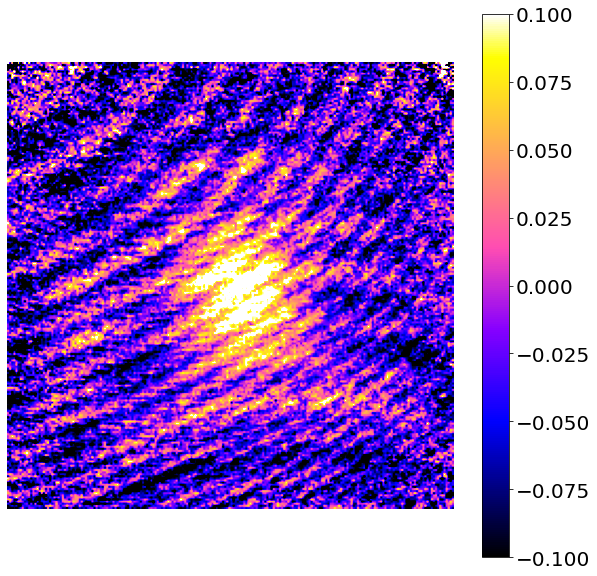

In [16]:
os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing")
plt.rcParams['figure.figsize'] = [10,10]
plot_image = plt.imshow(old_od_list[17], cmap = "gnuplot2", vmin = -0.1, vmax = 0.1)
colorbar = plt.colorbar(plot_image)
plt.axis("off")
colorbar.ax.yaxis.set_tick_params(labelsize=20, )  # Adjust the font size as needed
colorbar.ax.yaxis.get_offset_text().set(size=20, weight='bold')
#plt.savefig("noisy_od.png", dpi=1000)

In [17]:
cloud_size_guess = cloud_size_estimation(optical_density = old_od_list[0], density_start_idx1 = density_start_idx1, 
density_end_idx1 = density_end_idx1, density_start_idx2 = density_start_idx2, density_end_idx2 = density_end_idx2)
param_col, param_row = [], []
cloud_center_guess = round((np.argmax(np.sum(np.log(np.divide(ref_frames[-1], abs_frames[-1])), axis = 0)) + 
np.argmax(np.sum(np.log(np.divide(ref_frames[-1], abs_frames[-1])), axis = 1)))/2)
for i in range(nof_abs):
    p_col, cov_col = curve_fit(gauss, xdata, np.sum(old_od_list[i], axis = 0), 
    p0 = [np.min(np.sum(old_od_list[i], axis = 0)), np.max(np.sum(old_od_list[i], axis = 0)), cloud_center_guess, cloud_size_guess], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)
    p_row, cov_row = curve_fit(gauss, xdata, np.sum(old_od_list[i], axis = 1), 
    p0 = [np.min(np.sum(old_od_list[i], axis = 1)), np.max(np.sum(old_od_list[i], axis = 1)), cloud_center_guess, cloud_size_guess], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)
    param_col.append(p_col)
    param_row.append(p_row)
masked_abs_frames = hide_cloud(abs_frames = abs_frames, ref_frames = ref_frames, nof_abs = nof_abs, frame_dimension = frame_dimension, 
cloud_size_guess = cloud_size_guess, param_col = param_col, param_row = param_row)
new_ref_frames = denoise_by_pattern_recognise(abs_frames, masked_abs_frames, ref_frames, nof_abs, nof_ref, 
frame_dimension, density_start_idx1, density_end_idx1, density_start_idx2, density_end_idx2)
denoised_od_stage1 = [np.log(np.divide(new_ref_frames[i], abs_frames[i])) for i in range(nof_abs)]

(-0.5, 211.5, 211.5, -0.5)

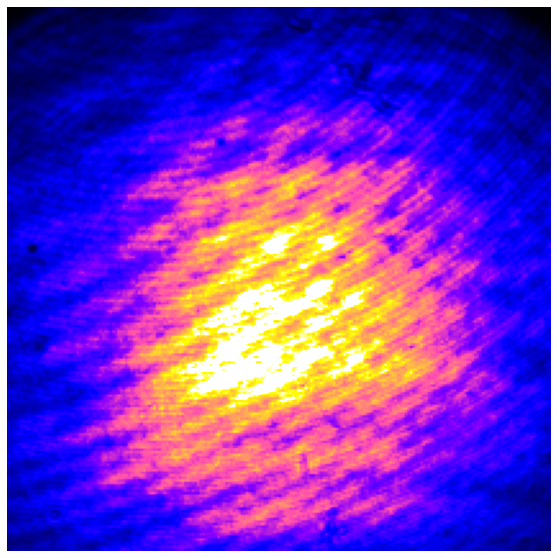

In [18]:
os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing")
plt.rcParams['figure.figsize'] = [10,10]
plot_image = plt.imshow(masked_abs_frames[0], cmap = "gnuplot2", vmin = 0, vmax = 0.01)
#colorbar = plt.colorbar(plot_image)
plt.axis("off")
# colorbar.ax.yaxis.set_tick_params(labelsize=20, )  # Adjust the font size as needed
# colorbar.ax.yaxis.get_offset_text().set(size=20, weight='bold')
#plt.savefig("abs_frame_masked.png", dpi=1000)

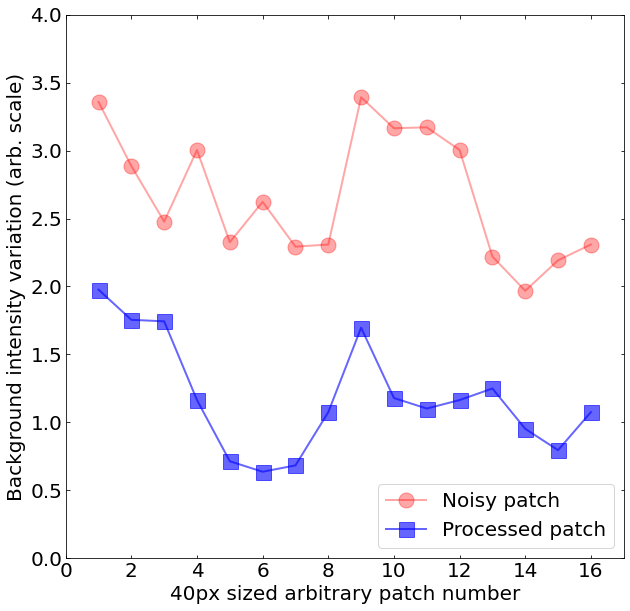

In [19]:
arr = old_od_list[17]
arrr = denoised_od_stage1[17]

top_old, bottom_old, left_old, right_old = [], [], [], []
top_new, bottom_new, left_new, right_new = [], [], [], []

for i in range(0,200,40):
    top_old.append(np.var(arr[0:40, i:i+40]))
for i in range(0,200,40):
    bottom_old.append(np.var(arr[160:200, i:i+40]))
for i in range(0,200,40):
    left_old.append(np.var(arr[i:i+40, 0:40]))
for i in range(0,200,40):
    right_old.append(np.var(arr[i:i+40, 160:200]))

for i in range(0,200,40):
    top_new.append(np.var(arrr[0:40, i:i+40]))
for i in range(0,200,40):
    bottom_new.append(np.var(arrr[160:200, i:i+40]))
for i in range(0,200,40):
    left_new.append(np.var(arrr[i:i+40, 0:40]))
for i in range(0,200,40):
    right_new.append(np.var(arrr[i:i+40, 160:200]))
xaxis = np.linspace(1,16,16)

old = np.concatenate((top_old, bottom_old, left_old, right_old), axis = 0)
new = np.concatenate((top_new, bottom_new, left_new, right_new), axis = 0)

old = np.delete(old, [0,4, 10, 15])
new = np.delete(new, [0,4, 10, 15])

plt.rcParams['figure.figsize'] = [10,10]
plt.plot(xaxis, old*1000, "ro-", alpha = 0.35, linewidth = 2, label = "Noisy patch", markersize=15)
plt.plot(xaxis, new*1000, "bs-", alpha = 0.6, linewidth = 2, label = "Processed patch", markersize=15)
plt.legend(fontsize="20", loc ="lower right")
plt.tick_params(direction = "in", right = "True", top = "True", labelsize = 20)
plt.xlim([0,17])
plt.ylim([0,4])
plt.xlabel("40px sized arbitrary patch number", fontsize = 20)
plt.ylabel("Background intensity variation (arb. scale)", fontsize = 20)
os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\paper")
#plt.savefig("intensity_fluctuation_new.png", dpi = 1000)

In [20]:
# os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\density_origin\patch_origin")
# np.savetxt("new.csv", new, delimiter=',')

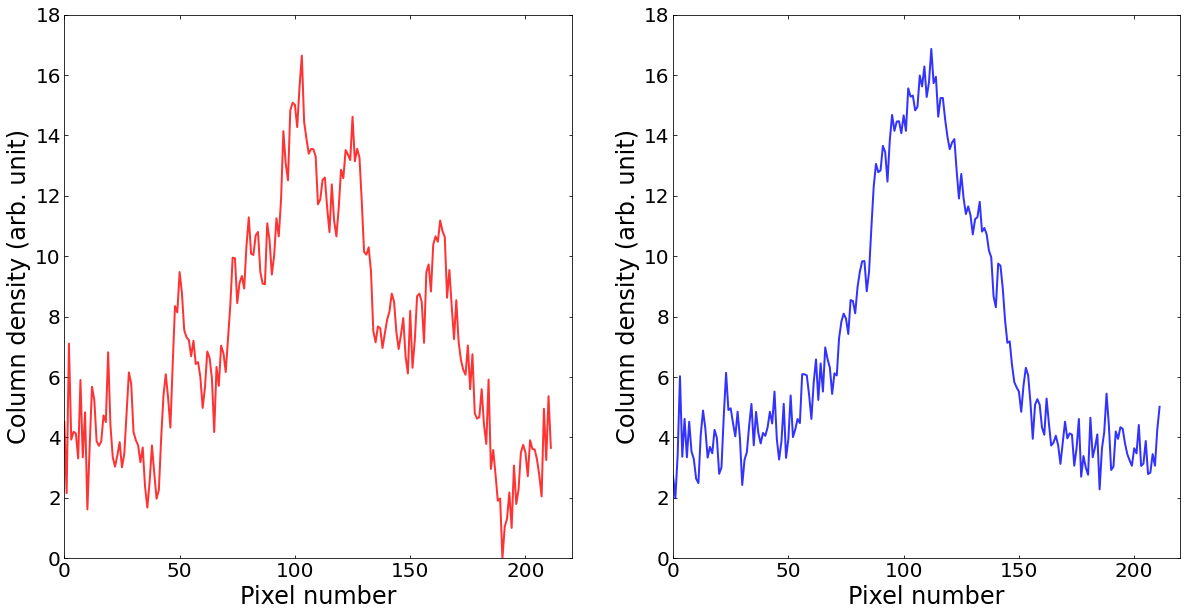

In [20]:
show_denoise_performance(old_od_list, denoised_od_stage1, 17, "hot", 0.1, -0.15, "Denoise by pattern recognition")

In [44]:
# unprocessed_od = denoised_od_stage1
# nlm_processed_od = [denoise(denoised_od_stage1[i], vertical_bg_start_1, vertical_bg_end_1, vertical_bg_start_2, vertical_bg_end_2, 
# horizontal_bg_start_1, horizontal_bg_end_1, horizontal_bg_start_2, horizontal_bg_end_2) for i in range(nof_abs)]

In [45]:
#show_denoise_performance(old_od_list, nlm_processed_od, 17, colormap, color_max, color_min, "Denoise by Non Local Means")

1. Introduction
2. Absorption Imaging system for ultracold atom cloud (schematic 1)
3. Algorithm for image denoising based on PCA (algo flowchart 2, importance of pca order 3)
4. Results and discussions (low snr (unprocessed, processed) 4, high snr (unprocessed,processed) 5)
5. Conclusion (snr with frames 6)

In [21]:
arr = old_od_list[16]
arrr = denoised_od_stage1[16]

In [22]:
param, covr = curve_fit(gauss, xdata, np.sum(arrr, axis = 1), 
    p0 = [np.min(np.sum(arrr, axis = 1)), np.max(np.sum(arrr, axis = 1)), 100, 20], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)

In [23]:
fitted_gauss = gauss(xdata, *param)

In [24]:
osp_right = round(param[2]+param[3]) #one standard-deviation point
osp_left = round(param[2]-param[3])
mu = round(param[2])
sigma = round(param[3])
confidence_zone = round(0.25*sigma)
osp_left, osp_right, mu, sigma, confidence_zone

(85, 131, 108, 23, 6)

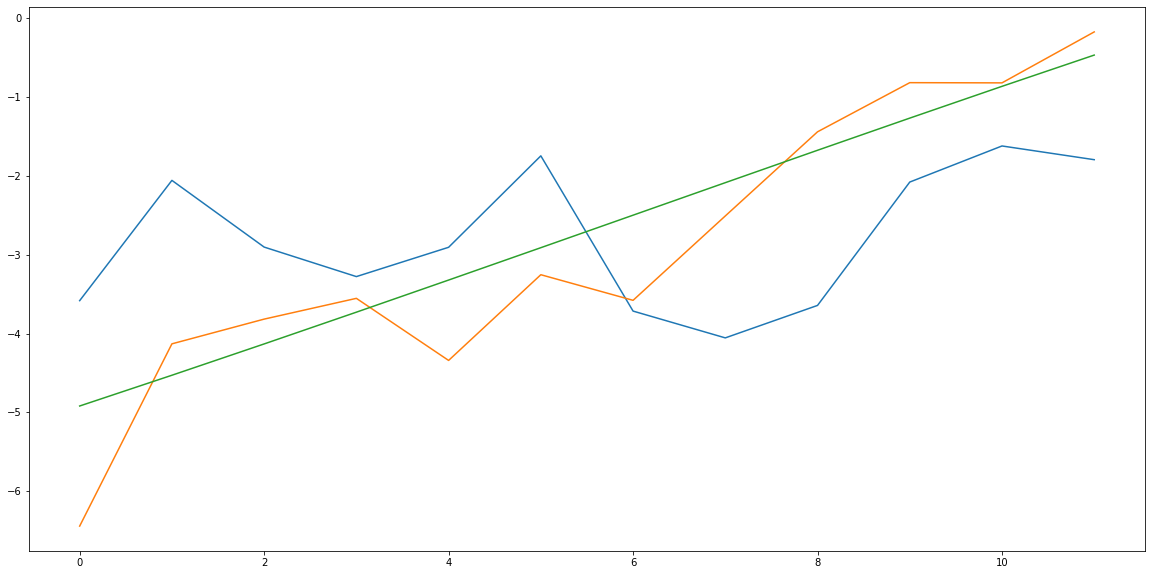

In [25]:
plt.plot(np.sum(arr, axis = 1)[osp_left-confidence_zone:osp_left+confidence_zone])
plt.plot(np.sum(arrr, axis = 1)[osp_left-confidence_zone:osp_left+confidence_zone])
plt.plot(fitted_gauss[osp_left-confidence_zone:osp_left+confidence_zone])

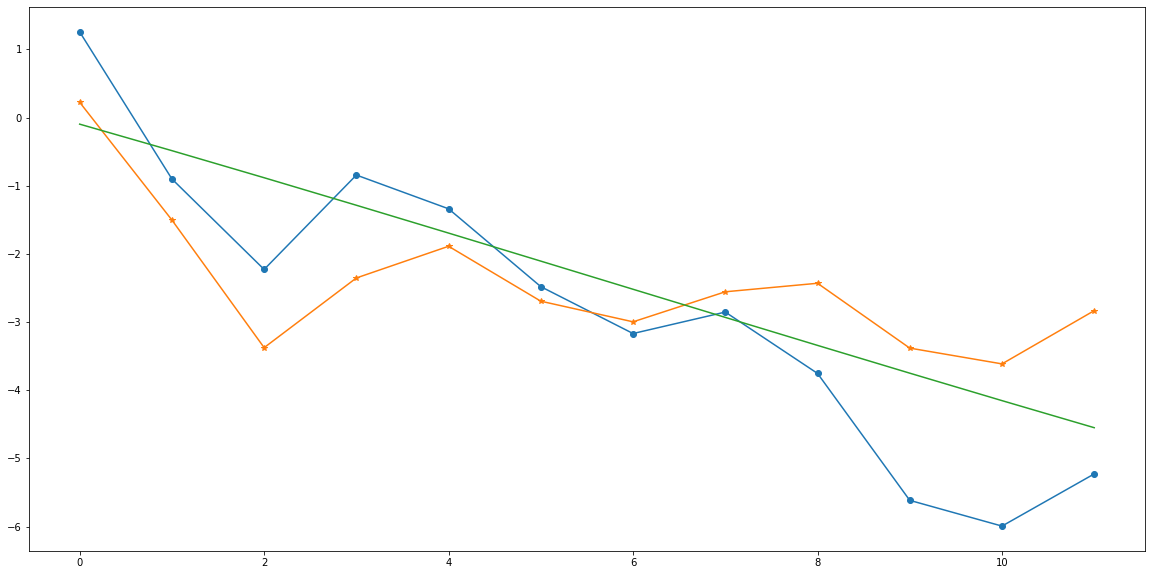

In [26]:
plt.plot(np.sum(arr, axis = 1)[osp_right-confidence_zone:osp_right+confidence_zone], "o-")
plt.plot(np.sum(arrr, axis = 1)[osp_right-confidence_zone:osp_right+confidence_zone], "*-")
plt.plot(fitted_gauss[osp_right-confidence_zone:osp_right+confidence_zone])

# calculate square deviation from fit

In [27]:
a1 = np.sum(arr, axis = 1)[osp_left-confidence_zone:osp_left+confidence_zone]
a2 = np.sum(arrr, axis = 1)[osp_left-confidence_zone:osp_left+confidence_zone]
a3 = fitted_gauss[osp_left-confidence_zone:osp_left+confidence_zone]

old_error = np.sqrt(np.sum((a3-a1)**2))/param[3]
new_error = np.sqrt(np.sum((a3-a2)**2))/param[3]

old_error, new_error

(0.21144857334174874, 0.10219525149048295)

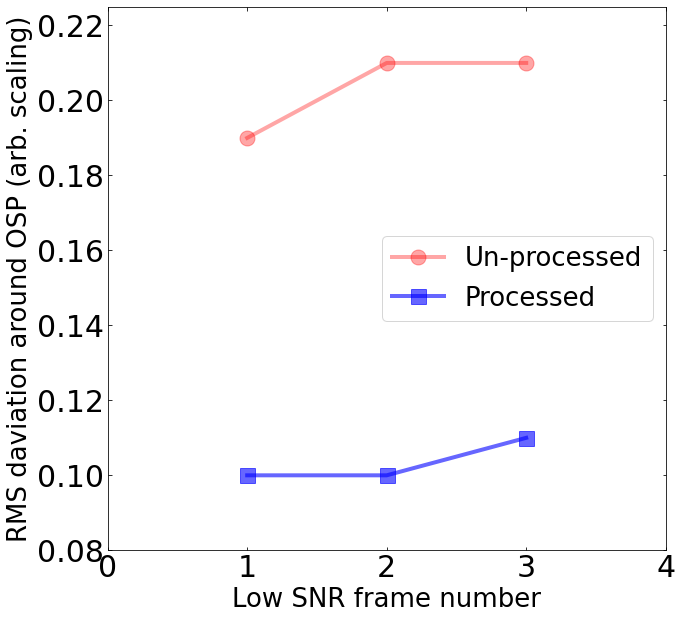

In [28]:
plt.rcParams['figure.figsize'] = [10,10]
x = [1,2,3]
o = [0.19, 0.21, 0.21]
n = [0.10,0.10 ,0.11]
plt.plot(x,o,"ro-", alpha = 0.35, linewidth = 4, label = "Un-processed", markersize=15)
plt.plot(x,n, "bs-", alpha = 0.6, linewidth = 4, label = "Processed", markersize=15)
plt.legend(fontsize="26", loc ="best")
plt.tick_params(direction = "in", right = "True", top = "True", labelsize = 30)
plt.xticks(np.arange(0, 5, 1))
plt.ylim([0.08,0.225])
plt.xlabel("Low SNR frame number", fontsize = 26)
plt.ylabel("RMS daviation around OSP (arb. scaling)", fontsize = 26)
os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\paper")
#plt.savefig("rms_deviation.png", dpi = 2000)

In [29]:
# os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\RMS_origin")
# np.savetxt("n.csv", n, delimiter=',')

In [30]:
np.shape(old_od_list[0])

(212, 212)

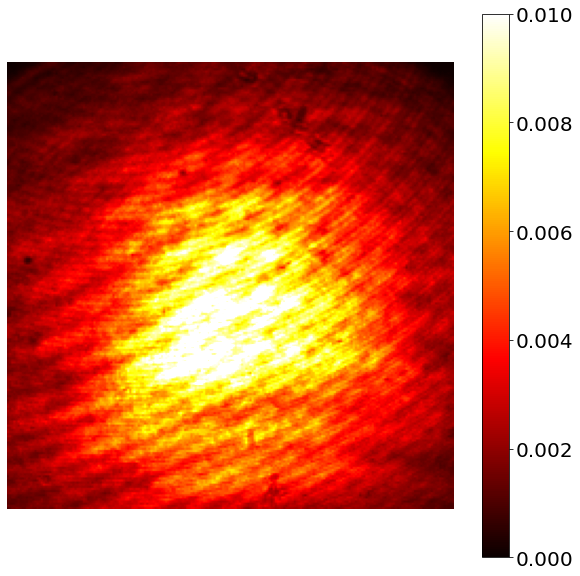

In [31]:
f1 = old_od_list[16]
f2 = ref_frames[14]
plt.rcParams['figure.figsize'] = [10,10]
plot_image = plt.imshow(f2, cmap = "hot", vmin = 0, vmax = 0.01)
colorbar = plt.colorbar(plot_image)
plt.axis("off")
colorbar.ax.yaxis.set_tick_params(labelsize=20, )  # Adjust the font size as needed
colorbar.ax.yaxis.get_offset_text().set(size=20, weight='bold')
#plt.savefig("ref_frame_with_colorbar.png", dpi = 1000)
plt.show()


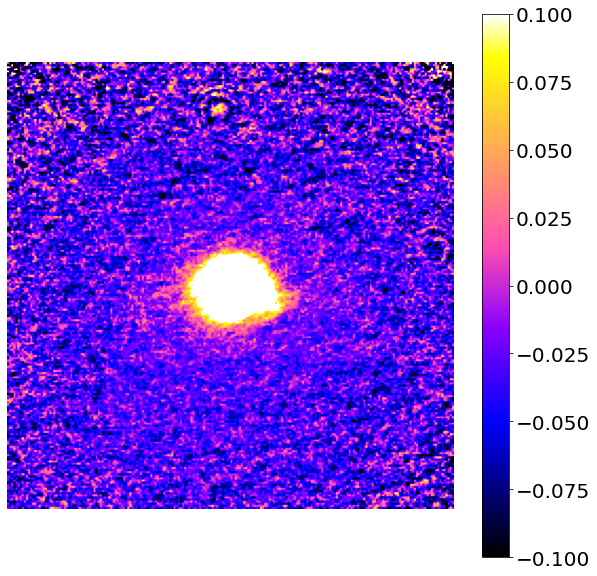

In [32]:
os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing")
plt.rcParams['figure.figsize'] = [10,10]
plot_image = plt.imshow(denoised_od_stage1[1], cmap = "gnuplot2", vmin = -0.1, vmax = 0.1)
colorbar = plt.colorbar(plot_image)
plt.axis("off")
colorbar.ax.yaxis.set_tick_params(labelsize=20, )  # Adjust the font size as needed
colorbar.ax.yaxis.get_offset_text().set(size=20, weight='bold')
#plt.savefig("hsnr_pro.png", dpi=1000)

In [127]:
# os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\density_origin")
# np.savetxt("lsnr_new.csv", np.sum(denoised_od_stage1[17], axis = 1), delimiter=',')

In [33]:
param_f1, covr_f1 = curve_fit(gauss, xdata, np.sum(f1, axis = 1), 
    p0 = [np.min(np.sum(f1, axis = 1)), np.max(np.sum(f1, axis = 1)), 100, 20], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)

param_f2, covr_f2 = curve_fit(gauss, xdata, np.sum(f2, axis = 1), 
    p0 = [np.min(np.sum(f2, axis = 1)), np.max(np.sum(f2, axis = 1)), 100, 20], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)

param_f1[-1], param_f2[-1]

(26.613543131403063, 57.95825299136816)

In [59]:
param_ff1, covr_ff1 = curve_fit(gauss, xdata, np.sum(ff1, axis = 1), 
    p0 = [np.min(np.sum(ff1, axis = 1)), np.max(np.sum(ff1, axis = 1)), 100, 20], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)

param_ff2, covr_ff2 = curve_fit(gauss, xdata, np.sum(ff2, axis = 1), 
    p0 = [np.min(np.sum(ff2, axis = 1)), np.max(np.sum(ff2, axis = 1)), 100, 20], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)

param_ff1[-1], param_ff2[-1]

(22.866808511233295, 23.396634187068717)

# all cycle

In [60]:
tau = np.array([1,3,5,7,9,10])

In [61]:
def stline(tdata, slope, intercept):
    return slope*tdata + intercept

In [62]:
sig_1_new = []
sig_1_new_cov = []
for i in range(0,6):
    p,c = curve_fit(gauss, xdata, np.sum(denoised_od_stage1[i], axis = 1), 
    p0 = [np.min(np.sum(denoised_od_stage1[i], axis = 1)), np.max(np.sum(denoised_od_stage1[i], axis = 1)), 100, 20], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)
    sig_1_new.append(p[-1])
    sig_1_new_cov.append(c)
sig_1_new = np.array(sig_1_new)
sig_1_new

array([ 6.76897146,  8.57915409, 13.72144188, 16.36740923, 18.83577691,
       21.2221336 ])

In [63]:
sig_1_new_err = [np.sqrt(np.diag(sig_1_new_cov[i])) for i in range(6)]
sig_1_new_err

[array([0.06892758, 0.32698722, 0.10277073, 0.10621577]),
 array([0.06632252, 0.27274742, 0.11275979, 0.11780002]),
 array([0.08673676, 0.26129547, 0.16333948, 0.17704994]),
 array([0.07712387, 0.2034901 , 0.16556308, 0.18377805]),
 array([0.07014854, 0.16488782, 0.25787759, 0.29385612]),
 array([0.06284891, 0.13264449, 0.24265586, 0.28498477])]

In [64]:
pt, ct = curve_fit(stline, tau**2, sig_1_new**2)
T=(pt[0]*(24*10**-6)**2*2.5**2*1.44*10**(-25))/(1.38*10**(-23))
T*10**12

147.7836330000091

In [65]:
sig_0_new = []
sig_0_new_cov = []
for i in range(0,6):
    p,c = curve_fit(gauss, xdata, np.sum(denoised_od_stage1[i], axis = 0), 
    p0 = [np.min(np.sum(denoised_od_stage1[i], axis = 0)), np.max(np.sum(denoised_od_stage1[i], axis = 0)), 100, 20], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)
    sig_0_new.append(p[-1])
    sig_0_new_cov.append(c)
sig_0_new = np.array(sig_0_new)
sig_0_new

array([ 7.95109197, 10.35890513, 15.61450844, 18.02179673, 20.14891563,
       22.79226191])

In [66]:
sig_0_new_err = [np.sqrt(np.diag(sig_0_new_cov[i])) for i in range(6)]
sig_0_new_err

[array([0.06713885, 0.28927882, 0.13211858, 0.13749446]),
 array([0.0559364 , 0.20414468, 0.12510284, 0.13221952]),
 array([0.05834133, 0.15966902, 0.13419958, 0.14789918]),
 array([0.05246064, 0.12802248, 0.14172732, 0.16003021]),
 array([0.05035179, 0.11150587, 0.23466088, 0.27169837]),
 array([0.05287123, 0.10404007, 0.25508309, 0.30659512])]

In [67]:
pt, ct = curve_fit(stline, tau**2, sig_0_new**2)
T=(pt[0]*(24*10**-6)**2*2.5**2*1.44*10**(-25))/(1.38*10**(-23))
T*10**12

162.01890542187203

In [68]:
sig_1_old = []
sig_1_old_cov = []
for i in range(6,12):
    p,c = curve_fit(gauss, xdata, np.sum(old_od_list[i], axis = 1), 
    p0 = [np.min(np.sum(old_od_list[i], axis = 1)), np.max(np.sum(old_od_list[i], axis = 1)), 100, 20], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)
    sig_1_old.append(p[-1])
    sig_1_old_cov.append(c)
sig_1_old = np.array(sig_1_old)
sig_1_old

array([ 7.90032011, 10.26897185, 12.63753   , 17.14429002, 20.49247703,
       29.25172381])

In [69]:
sig_1_old_err = [np.sqrt(np.diag(sig_1_old_cov[i])) for i in range(6)]
sig_1_old_err

[array([0.09153319, 0.39592135, 0.13198617, 0.13731478]),
 array([0.10242931, 0.37594791, 0.16089895, 0.16994774]),
 array([0.0868982 , 0.27748576, 0.22553255, 0.24234957]),
 array([0.1308544 , 0.33271548, 0.37946574, 0.42450436]),
 array([0.08351213, 0.18210691, 0.3282799 , 0.38178177]),
 array([0.1436321 , 0.21153337, 0.79021985, 1.08573849])]

In [70]:
pt, ct = curve_fit(stline, tau**2, sig_1_old**2)
T=(pt[0]*(24*10**-6)**2*2.5**2*1.44*10**(-25))/(1.38*10**(-23))
T*10**12

260.3413189855806

In [71]:
sig_0_old = []
sig_0_old_cov = []
for i in range(6,12):
    p,c = curve_fit(gauss, xdata, np.sum(old_od_list[i], axis = 0), 
    p0 = [np.min(np.sum(old_od_list[i], axis = 0)), np.max(np.sum(old_od_list[i], axis = 0)), 100, 20], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)
    sig_0_old.append(p[-1])
    sig_0_old_cov.append(c)
sig_0_old = np.array(sig_0_old)
sig_0_old

array([ 7.9329202 , 11.08849152, 14.02124678, 19.18696421, 23.36993727,
       38.59407733])

In [72]:
sig_0_old_err = [np.sqrt(np.diag(sig_0_old_cov[i])) for i in range(6)]
sig_0_old_err

[array([0.05875181, 0.25349357, 0.0981975 , 0.10218197]),
 array([0.08922731, 0.31140161, 0.17664852, 0.18764904]),
 array([0.10639034, 0.31552254, 0.32131807, 0.34916243]),
 array([0.1111432 , 0.25708666, 0.42984129, 0.49183427]),
 array([0.0814729 , 0.15625424, 0.36526859, 0.44312811]),
 array([0.19412234, 0.20000762, 0.78031463, 1.48269348])]

In [73]:
pt, ct = curve_fit(stline, tau**2, sig_0_old**2)
T=(pt[0]*(24*10**-6)**2*2.5**2*1.44*10**(-25))/(1.38*10**(-23))
T*10**12

444.5258776807746

In [74]:
# m = 2.5 #250/100
# up = (sig[5]*24*10**(-6)*m)**2 - (sig[0]*24*10**(-6)*m)**2
# down = (99)*10**(-6)
# ratio = (up/down)*10**(4)
# ratio

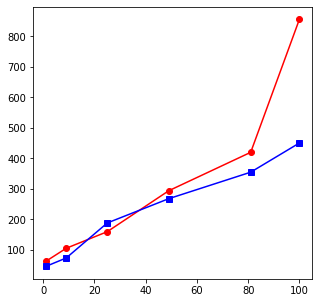

In [75]:
plt.plot(tau**2, sig_1_old**2, 'r-o')
plt.plot(tau**2, sig_1_new**2, 'b-s')

In [76]:
A=(24*10**(-6))**2
s0 = (3/(2*np.pi))*(780*10**(-9))**2
N = -(A/s0)*np.sum(old_od_list[17])*2.5**2
N*10**(-7)

1.4063113801794498

In [77]:
slope = 0.34693
T=(slope*(24*10**-6)**2*2.5**2*1.44*10**(-25))/(1.38*10**(-23))
T*10**12

13.032500869565224

# Constrained fitting

In [78]:
def gauss(xdata, off, amp, mu, sd):
    return off + amp * (np.exp(-(xdata - mu)**2 / (2*sd**2)))

def cont_gaussian(xdata, amplitude, stddev, fixed_offset, fixed_mean):
    return fixed_offset + amplitude * (np.exp(-(xdata - fixed_mean)**2 / (2*stddev**2)))

In [79]:
# Axis 0 new
off_0_new = []
amp_0_new = []
mean_0_new = []
sig_0_new = []
cov_0_new = []
for i in range(6,12):
    p,c = curve_fit(gauss, xdata, np.sum(denoised_od_stage1[i], axis = 0), 
    p0 = [np.min(np.sum(denoised_od_stage1[i], axis = 0)), np.max(np.sum(denoised_od_stage1[i], axis = 0)), 100, 30], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)
    off_0_new.append(p[0])
    amp_0_new.append(p[1])
    mean_0_new.append(p[2])
    sig_0_new.append(p[3])
    cov_0_new.append(c)
off_0_new = np.array(off_0_new)
amp_0_new = np.array(amp_0_new)
mean_0_new = np.array(mean_0_new)
sig_0_new = np.array(sig_0_new)

# Axis 1 new
off_1_new = []
amp_1_new = []
mean_1_new = []
sig_1_new = []
cov_1_new = []
for i in range(6,12):
    p,c = curve_fit(gauss, xdata, np.sum(denoised_od_stage1[i], axis = 1), 
    p0 = [np.min(np.sum(denoised_od_stage1[i], axis = 1)), np.max(np.sum(denoised_od_stage1[i], axis = 1)), 100, 30], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)
    off_1_new.append(p[0])
    amp_1_new.append(p[1])
    mean_1_new.append(p[2])
    sig_1_new.append(p[3])
    cov_1_new.append(c)
off_1_new = np.array(off_1_new)
amp_1_new = np.array(amp_1_new)
mean_1_new = np.array(mean_1_new)
sig_1_new = np.array(sig_1_new)

err_0_new = [np.sqrt(np.diag(cov_0_new[i])) for i in range(6)]
err_1_new = [np.sqrt(np.diag(cov_1_new[i])) for i in range(6)]

In [80]:
# Axis 0 old
off_0_old = []
amp_0_old = []
mean_0_old = []
sig_0_old = []
cov_0_old = []
for i in range(6,12):
    p, c = curve_fit(gauss, xdata, np.sum(old_od_list[i], axis = 0), 
    p0 = [np.min(np.sum(old_od_list[i], axis = 0)), np.max(np.sum(old_od_list[i], axis = 0)), 100, 30], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)
    off_0_old.append(p[0])
    amp_0_old.append(p[1])
    mean_0_old.append(p[2])
    sig_0_old.append(p[3])
    cov_0_old.append(c)
off_0_old = np.array(off_0_old)
amp_0_old = np.array(amp_0_old)
mean_0_old = np.array(mean_0_old)
sig_0_old = np.array(sig_0_old)

# Axis 1 old
off_1_old = []
amp_1_old = []
mean_1_old = []
sig_1_old = []
cov_1_old = []
for i in range(6,12):
    p, c = curve_fit(gauss, xdata, np.sum(old_od_list[i], axis = 1), 
    p0 = [np.min(np.sum(old_od_list[i], axis = 1)), np.max(np.sum(old_od_list[i], axis = 1)), 100, 30], 
    method = gaussian_function_fiiting_method, maxfev = gaussian_function_fiiting_max_iteration)
    off_1_old.append(p[0])
    amp_1_old.append(p[1])
    mean_1_old.append(p[2])
    sig_1_old.append(p[3])
    cov_1_old.append(c)
off_1_old = np.array(off_1_old)
amp_1_old = np.array(amp_1_old)
mean_1_old = np.array(mean_1_old)
sig_1_old = np.array(sig_1_old)

err_0_old = [np.sqrt(np.diag(cov_0_old[i])) for i in range(6)]
err_1_old = [np.sqrt(np.diag(cov_1_old[i])) for i in range(6)]

In [81]:
sig_0_old[4], sig_0_old[5]

(23.37004214956965, 38.59471969686915)

In [82]:
df = pd.DataFrame()
for i in range(12,18):
    df.insert(i-12, f"sum_1_6", np.sum(denoised_od_stage1[i], axis = 0), True)
df.to_csv('od.csv', header=False, index=False)

# Density density correlation

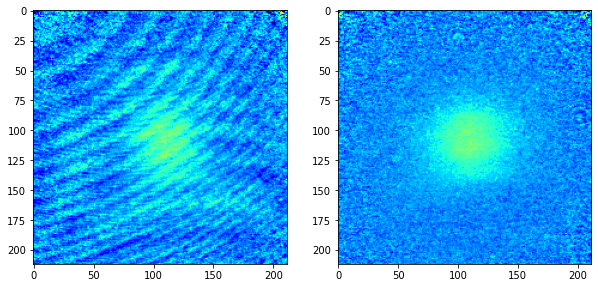

In [34]:
plt.rcParams['figure.figsize'] = [10,10]
plt.subplot(1,2,1)
plt.imshow(old_od_list[17], cmap="jet", vmin=color_min, vmax=color_max)
plt.subplot(1,2,2)
plt.imshow(denoised_od_stage1[17], cmap="jet", vmin=color_min, vmax=color_max)

# Without binning

In [35]:
roi = old_od_list[16][100:130,100:130]
intensities = roi.flatten()
mean_intensity = np.mean(intensities)
correlation_old = np.zeros(roi.shape[0])
# Calculate the intensity-intensity correlation for each pair of pixels
for i in range(roi.shape[0]):
    for j in range(i, roi.shape[0]):
        correlation_distance = abs(i - j)
        correlation_value = (intensities[i] * intensities[j]) / (mean_intensity ** 2)
        correlation_old[correlation_distance] += correlation_value
# Normalize the correlation by the number of pairs at each distance
correlation_old = correlation_old / (np.arange(0, roi.shape[0]) + 1)
distance = np.arange(0, roi.shape[0])

In [36]:
roi = denoised_od_stage1[16][100:130,100:130]
intensities = roi.flatten()
mean_intensity = np.mean(intensities)
correlation_new = np.zeros(roi.shape[0])
# Calculate the intensity-intensity correlation for each pair of pixels
for i in range(roi.shape[0]):
    for j in range(i, roi.shape[0]):
        correlation_distance = abs(i - j)
        correlation_value = (intensities[i] * intensities[j]) / (mean_intensity ** 2)
        correlation_new[correlation_distance] += correlation_value
# Normalize the correlation by the number of pairs at each distance
correlation_new = correlation_new / (np.arange(0, roi.shape[0]) + 1)

Text(0, 0.5, 'Density-density correlation (arb. unit)')

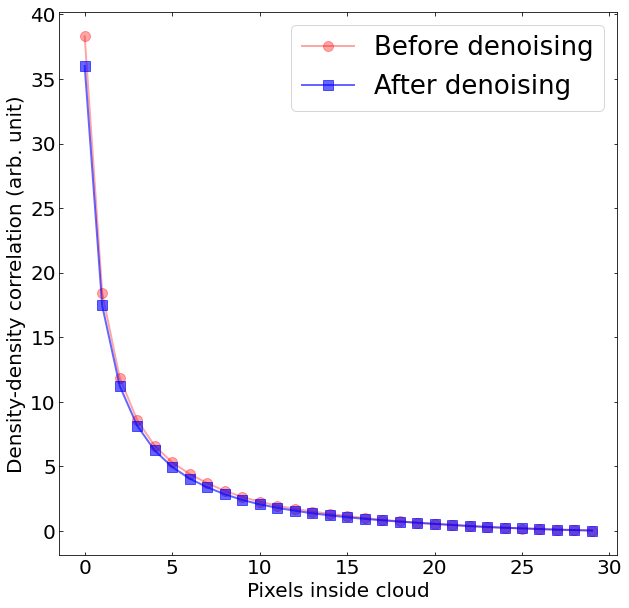

In [37]:
plt.rcParams['figure.figsize'] = [10,10]
plt.plot(distance,correlation_old, "ro-", alpha = 0.35, linewidth = 2, label = "Before denoising", markersize=10)
plt.plot(distance, correlation_new, "bs-", alpha = 0.6, linewidth = 2, label = "After denoising", markersize=10)
plt.legend(fontsize = "26", loc = "best")
plt.tick_params(direction = "in", right = "True", top = "True", labelsize = 20)
plt.xlabel('Pixels inside cloud', fontsize = "20")
plt.ylabel('Density-density correlation (arb. unit)', fontsize = "20")
#plt.savefig("density_density_corr.png", dpi = 1000)

In [40]:
os.chdir(r"P:\Python Codes\Image Denoising\Absorption_Image_Denoinsing\correlation_origin")
np.savetxt("corr_new.csv", correlation_new, delimiter=',')